In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import torch

In [2]:
import elfragmentador
elfragmentador.__version__

'0.36.0'

In [3]:
from elfragmentador.model import PepTransformerModel
from elfragmentador import constants

model = PepTransformerModel.load_from_checkpoint(
    "https://github.com/jspaezp/elfragmentador/releases/download/v0.33.0/0.33.0_onecycle_5e_petite_v_l.0.027061_epoch.004.ckpt"
)
model.eval()

PepTransformerModel(
  (encoder): _PeptideTransformerEncoder(
    (aa_encoder): AASequenceEmbedding(
      (fw_position_embed): SeqPositionalEmbed()
      (rev_position_embed): SeqPositionalEmbed()
      (aa_encoder): Embedding(24, 200, padding_idx=0)
      (mod_encoder): Embedding(14, 200, padding_idx=0)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): _LinearWithBias(in_features=224, out_features=224, bias=True)
          )
          (linear1): Linear(in_features=224, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=224, bias=True)
          (norm1): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((224,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1,

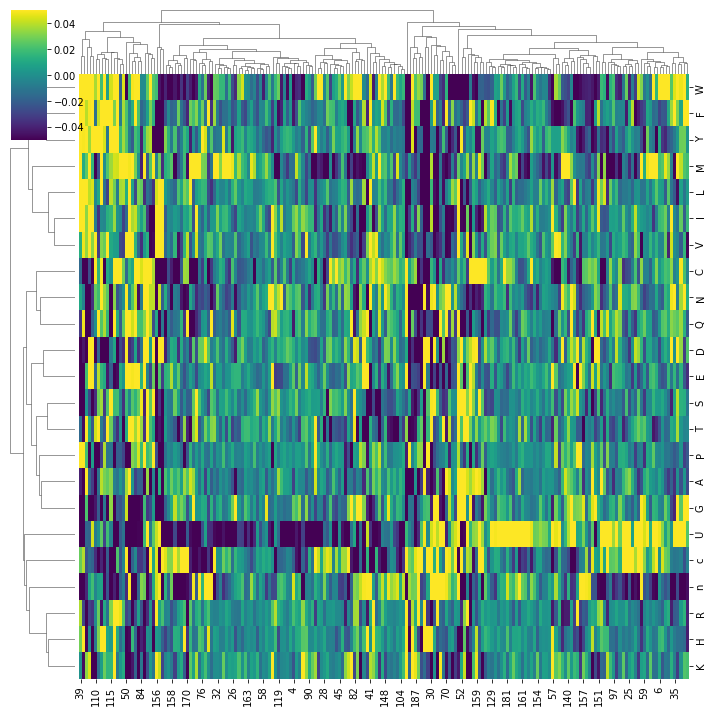

In [4]:
AAS = list(constants.ALPHABET.keys())
AA_NAMES = ["#"] + AAS

aa_weight_df = pd.DataFrame(model.encoder.aa_encoder.aa_encoder.weight.data.numpy(), index = AA_NAMES)
aa_weights = aa_weight_df.loc[[x for x in AAS]]
p = sns.clustermap(
    aa_weights, z_score = None, col_cluster=True,
    cmap = 'viridis',
    figsize = (10,10), dendrogram_ratio = (0.1, 0.1),
    method = "ward", vmin=-0.05, vmax=0.05)

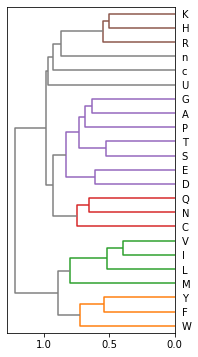

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Calculate the distance between each sample
Z = linkage(aa_weights, 'ward')
 
# Make the dendro
plt.subplots(figsize=(3, 6))
dendrogram(Z, labels=aa_weights.index, orientation="left", color_threshold=0.85, above_threshold_color='grey', distance_sort='ascending')
plt.show()

(23, 2)


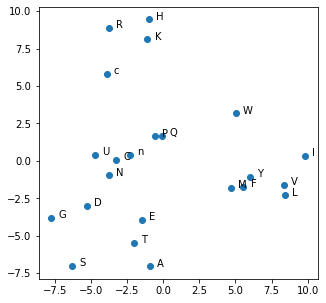

In [6]:

x = StandardScaler().fit_transform(aa_weights.values.T).T

pca = PCA(n_components = 2)
pca_weights = pca.fit_transform(x)
print(pca_weights.shape)

plt.subplots(figsize=(5, 5))
plt.scatter(pca_weights[...,0], pca_weights[...,1])
for i in range(0, len(aa_weights)):
    plt.text(pca_weights[i,0] + 0.5, pca_weights[i,1], aa_weights.index[i])

plt.show()


In [11]:
from elfragmentador import visualization

with visualization.SelfAttentionExplorer(model) as sae:
    _ = model.predict_from_seq("FELNDDYPSLPSMGWAS", 2, 30)
    _ = model.predict_from_seq("FELNDDYPSLPS[PHOSPHO]MGWAS", 2, 30)

sae

>>> SelfAttentionExplorer <<<<

>> AA sequences (aa_seqs):
{Embedding(24, 200, padding_idx=0): ['nFELNDDYPSLPSMGWASc', 'nFELNDDYPSLPSMGWASc']}
>> Charges (charges):
{ConcatenationEncoder(
  (dropout): Dropout(p=0.1, inplace=False)
): [2, 2]}
>> Encoder vizs (encoder_viz) torch.Size([2, 32, 32]):
{MultiheadAttention(
  (out_proj): _LinearWithBias(in_features=224, out_features=224, bias=True)
): tensor([[[0.0412, 0.0506, 0.0306,  ..., 0.0000, 0.0000, 0.0000],
         [0.1111, 0.0840, 0.0852,  ..., 0.0000, 0.0000, 0.0000],
         [0.1132, 0.1470, 0.0474,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0095, 0.1749, 0.0491,  ..., 0.0000, 0.0000, 0.0000],
         [0.0095, 0.1749, 0.0491,  ..., 0.0000, 0.0000, 0.0000],
         [0.0095, 0.1749, 0.0491,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0273, 0.0311, 0.0231,  ..., 0.0000, 0.0000, 0.0000],
         [0.1112, 0.0840, 0.0856,  ..., 0.0000, 0.0000, 0.0000],
         [0.1139, 0.1468, 0.0476,  ..., 0.0000, 0.0000, 0.0000],
  

<AxesSubplot:>

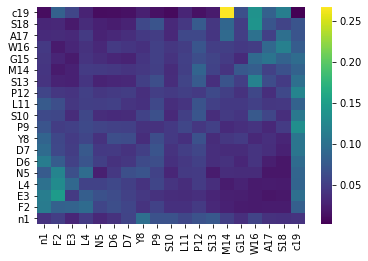

In [12]:
attn_vals = sae.get_encoder_attn(layer=0, index=0)
sns.heatmap(
    attn_vals,
    cmap = 'viridis')


<AxesSubplot:>

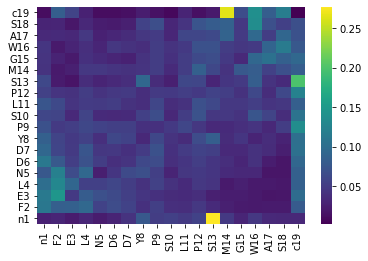

In [13]:
attn_vals = sae.get_encoder_attn(layer=0, index=1)
sns.heatmap(
    attn_vals,
    cmap = 'viridis')

<AxesSubplot:>

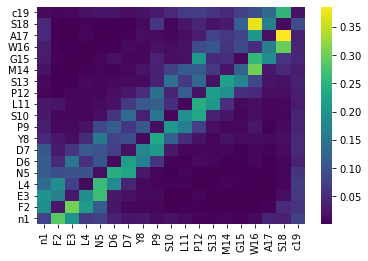

In [15]:
sns.heatmap(
    sae.get_encoder_attn(layer=1, index=0),
    cmap = 'viridis')

<AxesSubplot:>

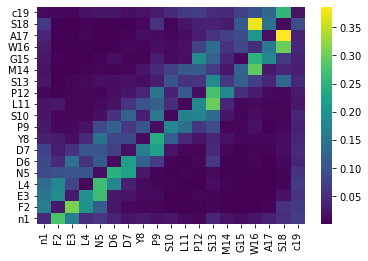

In [16]:
sns.heatmap(
    sae.get_encoder_attn(layer=1, index=1),
    cmap = 'viridis')

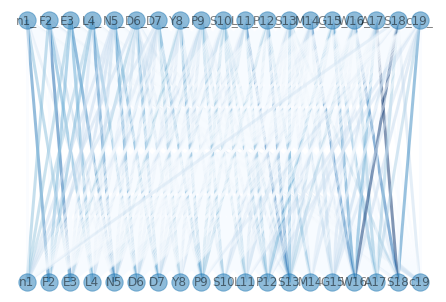

In [18]:
visualization.plot_bipartite_seq(
    visualization.make_bipartite(
        sae.get_encoder_attn(layer=1, index=1))
)

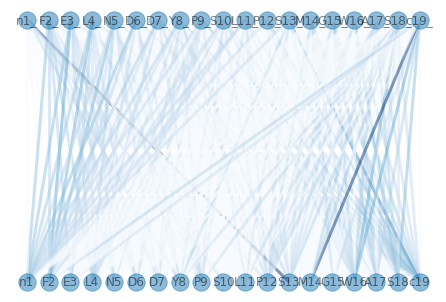

In [19]:
visualization.plot_bipartite_seq(
    visualization.make_bipartite(
        sae.get_encoder_attn(layer=0, index=1))
)